# Including a starting model
Here we will expand the `simple_inversion.ipynb` example by showing how to incorporate a non-flat starting model. A typical scenario for where this is useful is if you have a few point measurements of the elevations of the surface you are aiming to recover. These point measurements, referred to here as `constraints`, may be boreholes, acoustic basement from seismic surveys, or other types of measurements.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import xarray as xr
from polartoolkit import utils as polar_utils

from invert4geom import inversion, plotting, regional, synthetic, utils

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

## Get a synthetic model
Here we will load synthetic topography data, calculate its forward gravity with added noise, and sample the topography at 10 random points which represent places we have measurements of the topography (from boreholes for example). We will then interpolate these 10 points to make a starting model of topography.

INFO:invert4geom:RMSE at the constraints between the starting and true topography: 19.262348539866753 m


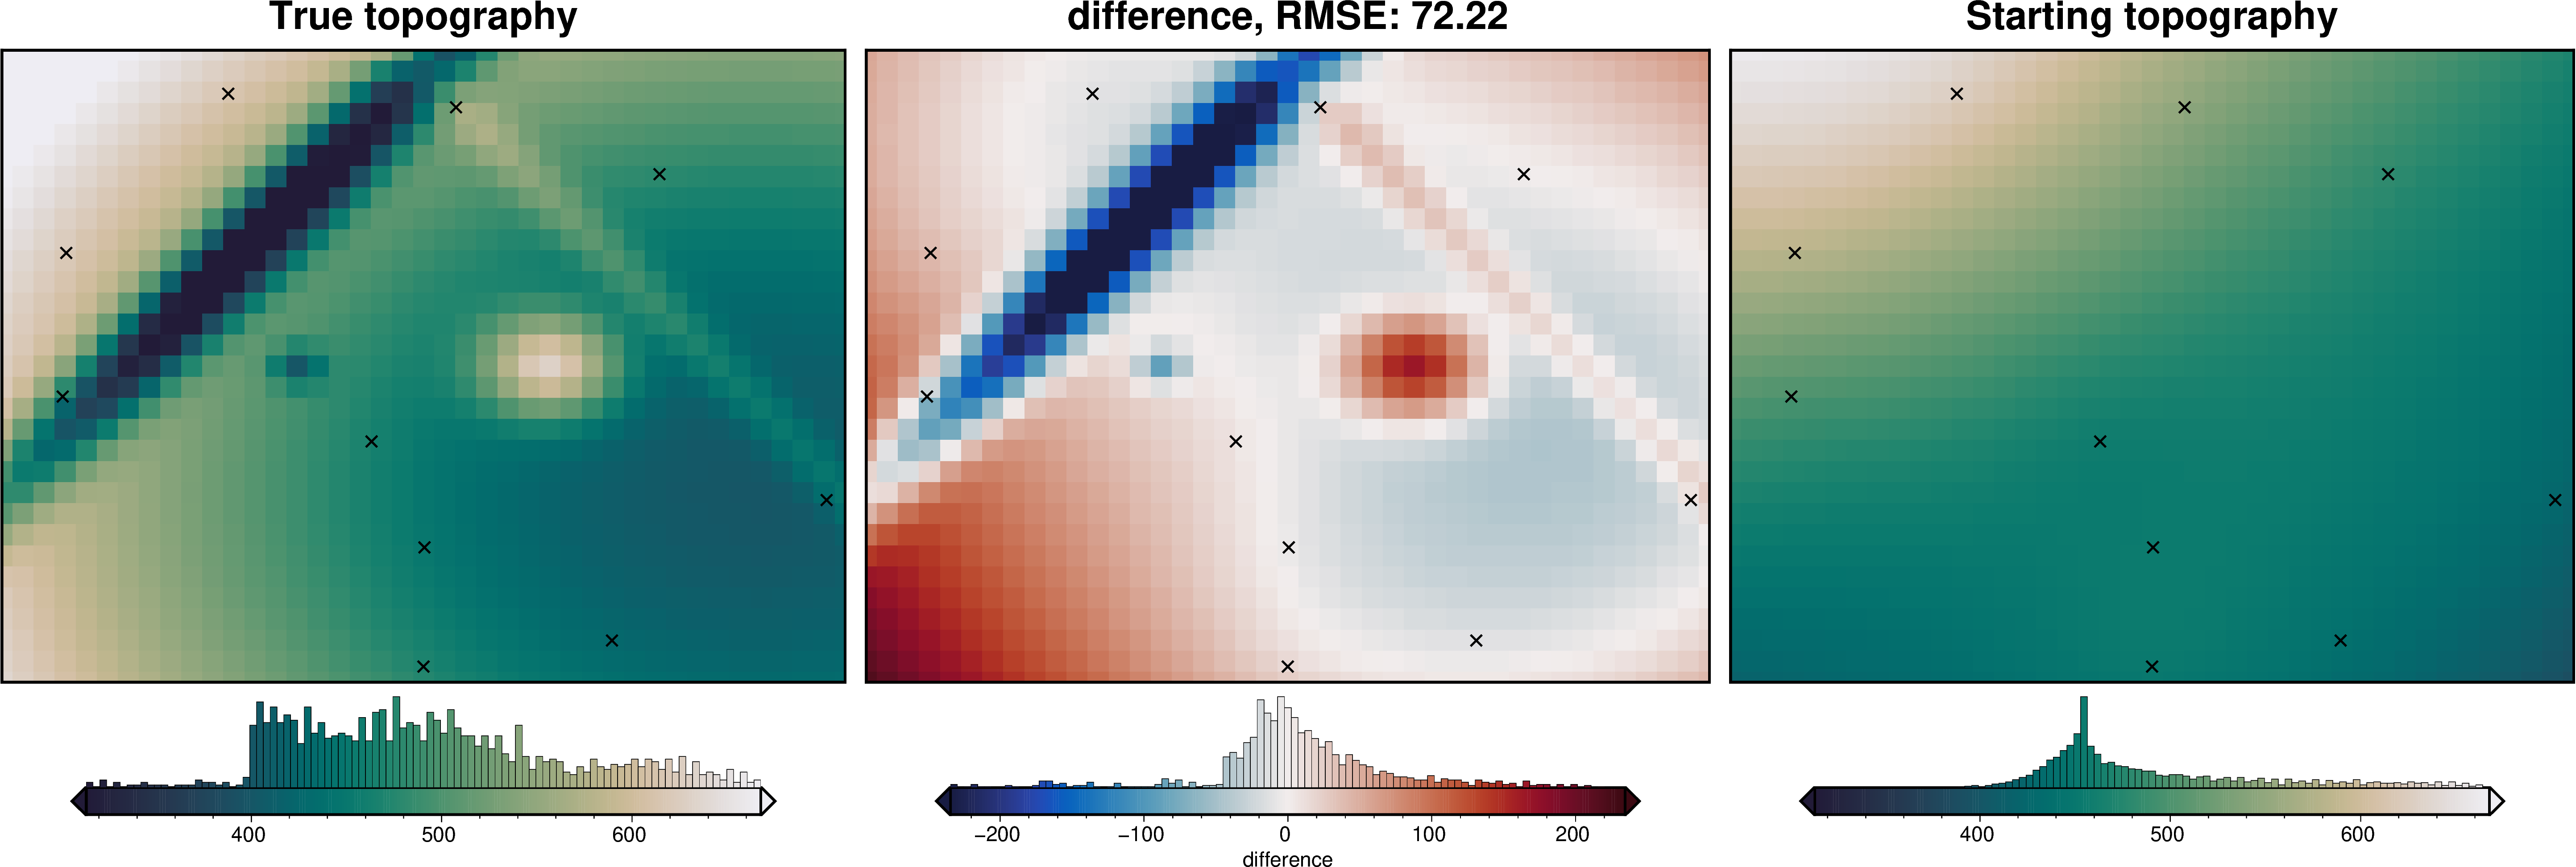

INFO:invert4geom:Standard deviation used for noise: [0.2]


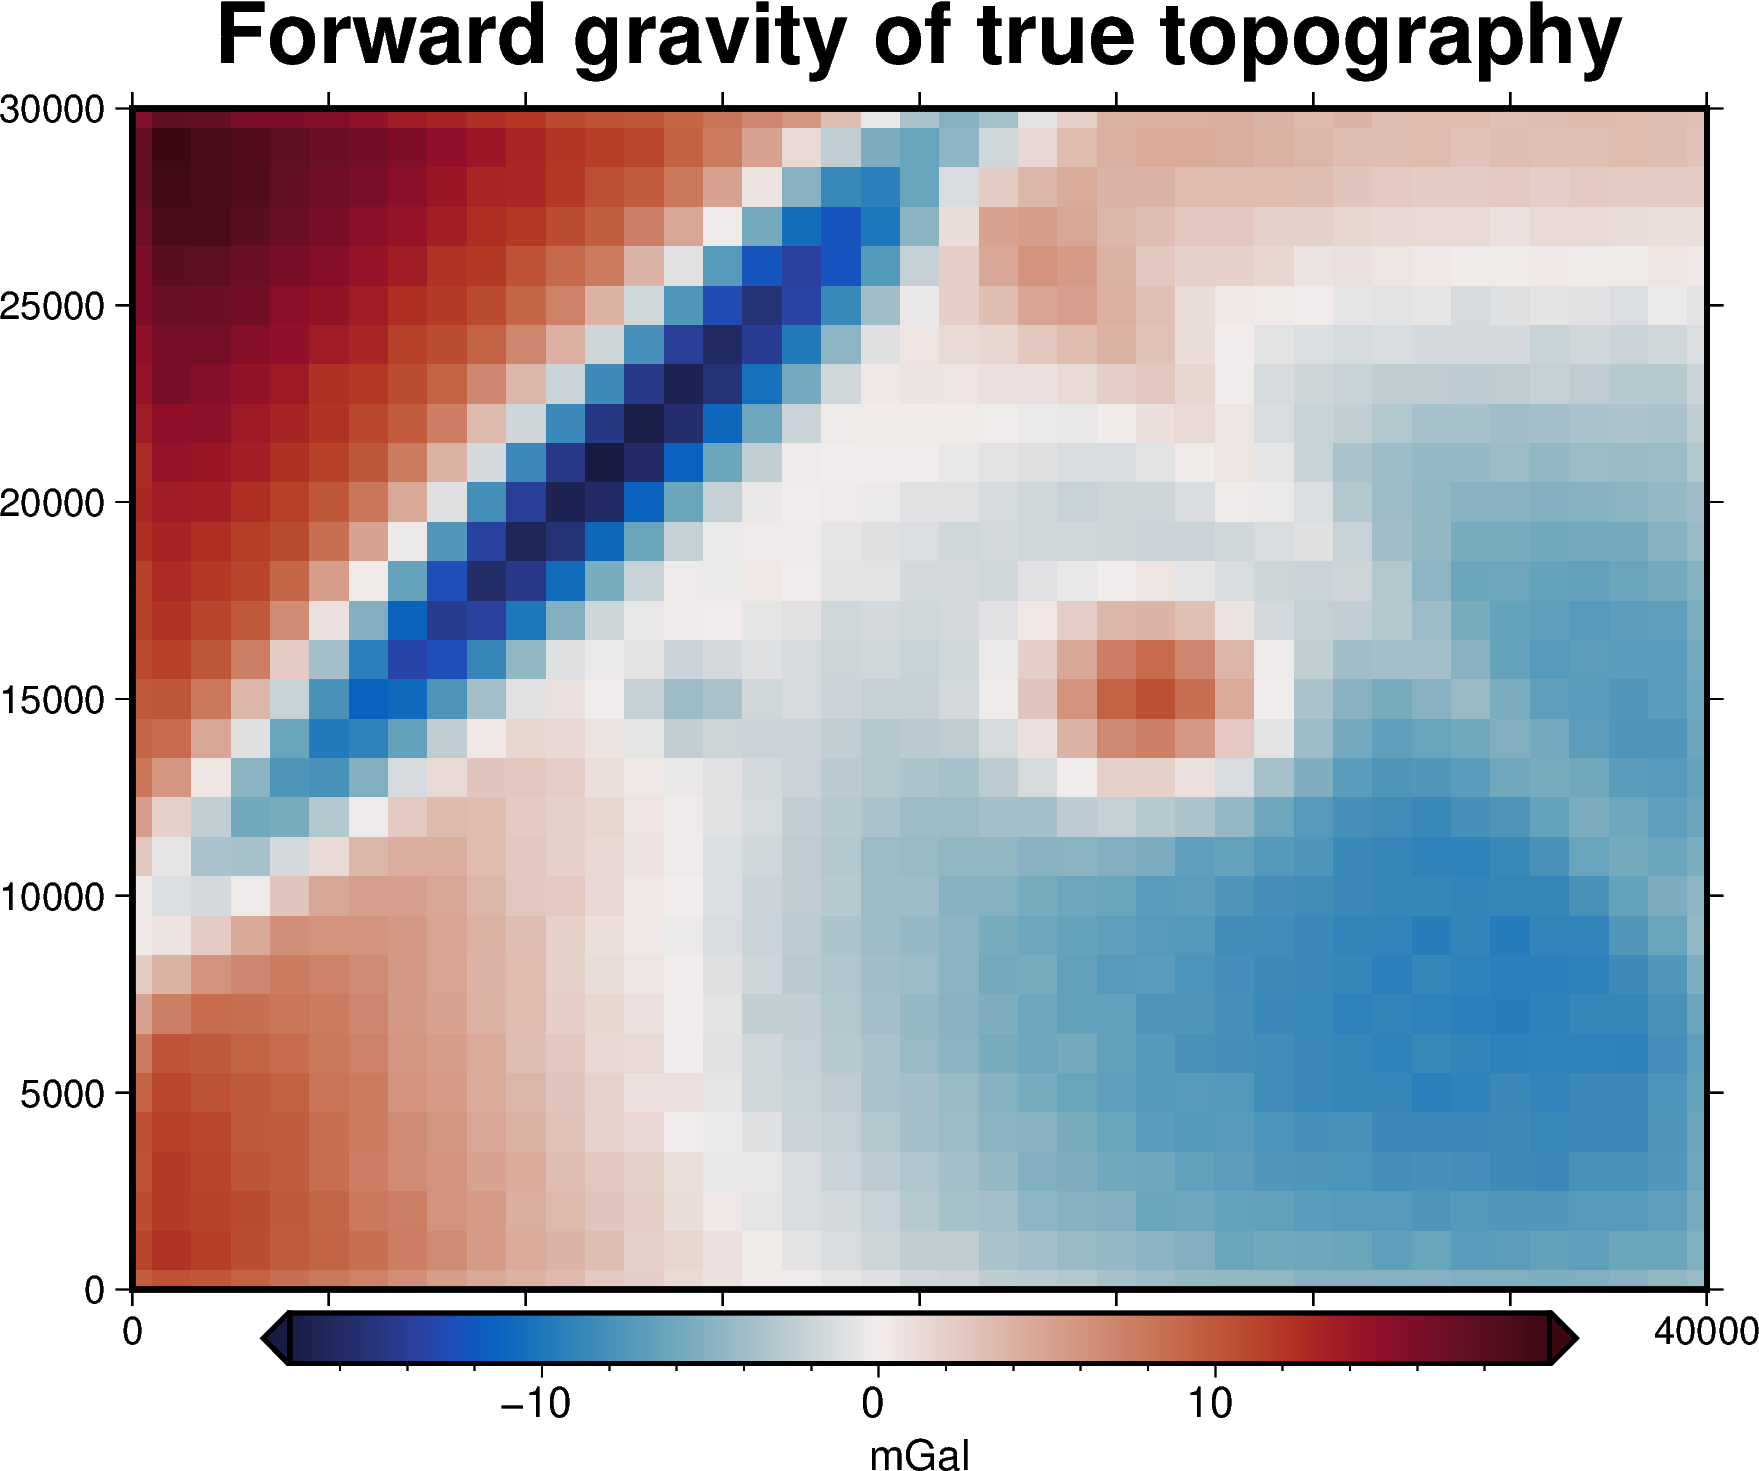

In [2]:
spacing = 1000
region = (0, 40000, 0, 30000)

# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

(
    true_topography,
    starting_topography,
    constraint_points,
    grav_df,
) = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
    number_of_constraints=10,
    density_contrast=density_contrast,
)

In [3]:
constraint_points

,easting,northing,upward,starting_topography
0,3052.331575,20376.899884,619.779099,580.163740
1,31196.751690,24112.171083,479.563412,481.652035
2,17536.369258,11428.233994,465.786893,458.230368
3,28938.607113,1978.090407,426.413502,438.512760
4,39119.580480,8644.367979,428.773305,425.210470
5,21539.834816,27287.805832,546.901160,547.287244
6,20044.818546,6401.560607,450.406755,455.069067
7,2882.045334,13563.718855,460.979806,499.138482
8,10737.559204,27936.180591,614.084318,624.948915
9,19995.300033,746.976827,470.409607,452.397262


In [4]:
grav_df

,northing,easting,upward,gravity_anomaly
0,0.0,0.0,1000.0,9.567870
1,0.0,1000.0,1000.0,10.404494
2,0.0,2000.0,1000.0,10.086139
3,0.0,3000.0,1000.0,9.298340
4,0.0,4000.0,1000.0,8.433107
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.117319
1267,30000.0,37000.0,1000.0,3.471562
1268,30000.0,38000.0,1000.0,3.402009
1269,30000.0,39000.0,1000.0,3.119660


## Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

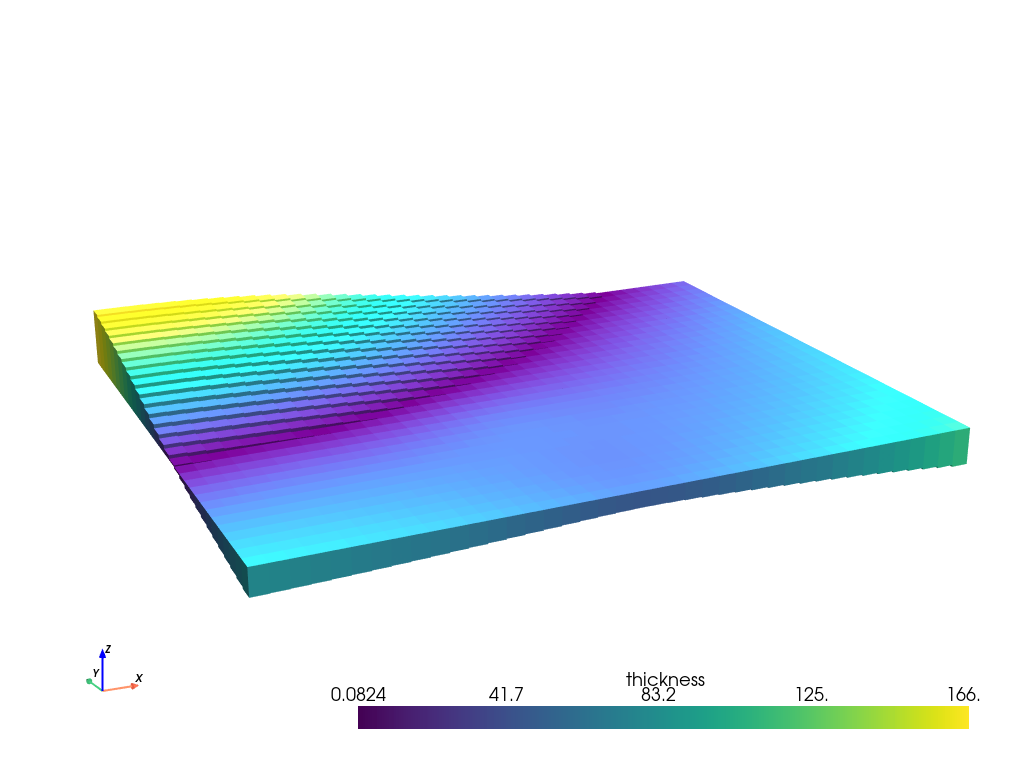

In [5]:
# set the reference level to the mean of the constraints
zref = constraint_points.upward.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    reference=zref,
    density=density_grid,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [6]:
# calculate forward gravity of starting prism layer
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# estimate regional with the mean misfit at constraints
grav_df = regional.regional_constant(
    grav_df=grav_df,
    constraints_df=constraint_points,
)

grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

INFO:invert4geom:using median gravity misfit of constraint points for regional field: 0.054823849646147 mGal


,northing,easting,upward,gravity_anomaly,starting_gravity,misfit,reg,res
0,0.0,0.0,1000.0,9.567870,-4.615609,14.183479,0.054824,14.128656
1,0.0,1000.0,1000.0,10.404494,-5.478021,15.882515,0.054824,15.827691
2,0.0,2000.0,1000.0,10.086139,-5.616354,15.702493,0.054824,15.647669
3,0.0,3000.0,1000.0,9.298340,-5.621009,14.919350,0.054824,14.864526
4,0.0,4000.0,1000.0,8.433107,-5.577819,14.010926,0.054824,13.956102
...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.117319,-0.899069,4.016388,0.054824,3.961564
1267,30000.0,37000.0,1000.0,3.471562,-1.229882,4.701445,0.054824,4.646621
1268,30000.0,38000.0,1000.0,3.402009,-1.539314,4.941323,0.054824,4.886499
1269,30000.0,39000.0,1000.0,3.119660,-1.788530,4.908190,0.054824,4.853366


## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

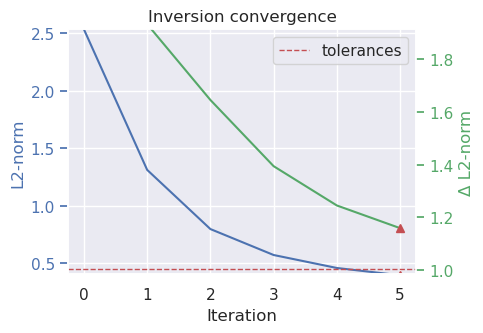

In [7]:
# set Python's logging level to suppress information about the inversion\s progress
logging.getLogger().setLevel(logging.WARN)

# run the inversion
results = inversion.run_inversion(
    grav_df=grav_df,
    prism_layer=starting_prisms,
    # display the convergence of the inversion
    plot_dynamic_convergence=True,
    solver_damping=0.06,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.45,
    delta_l2_norm_tolerance=1.005,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

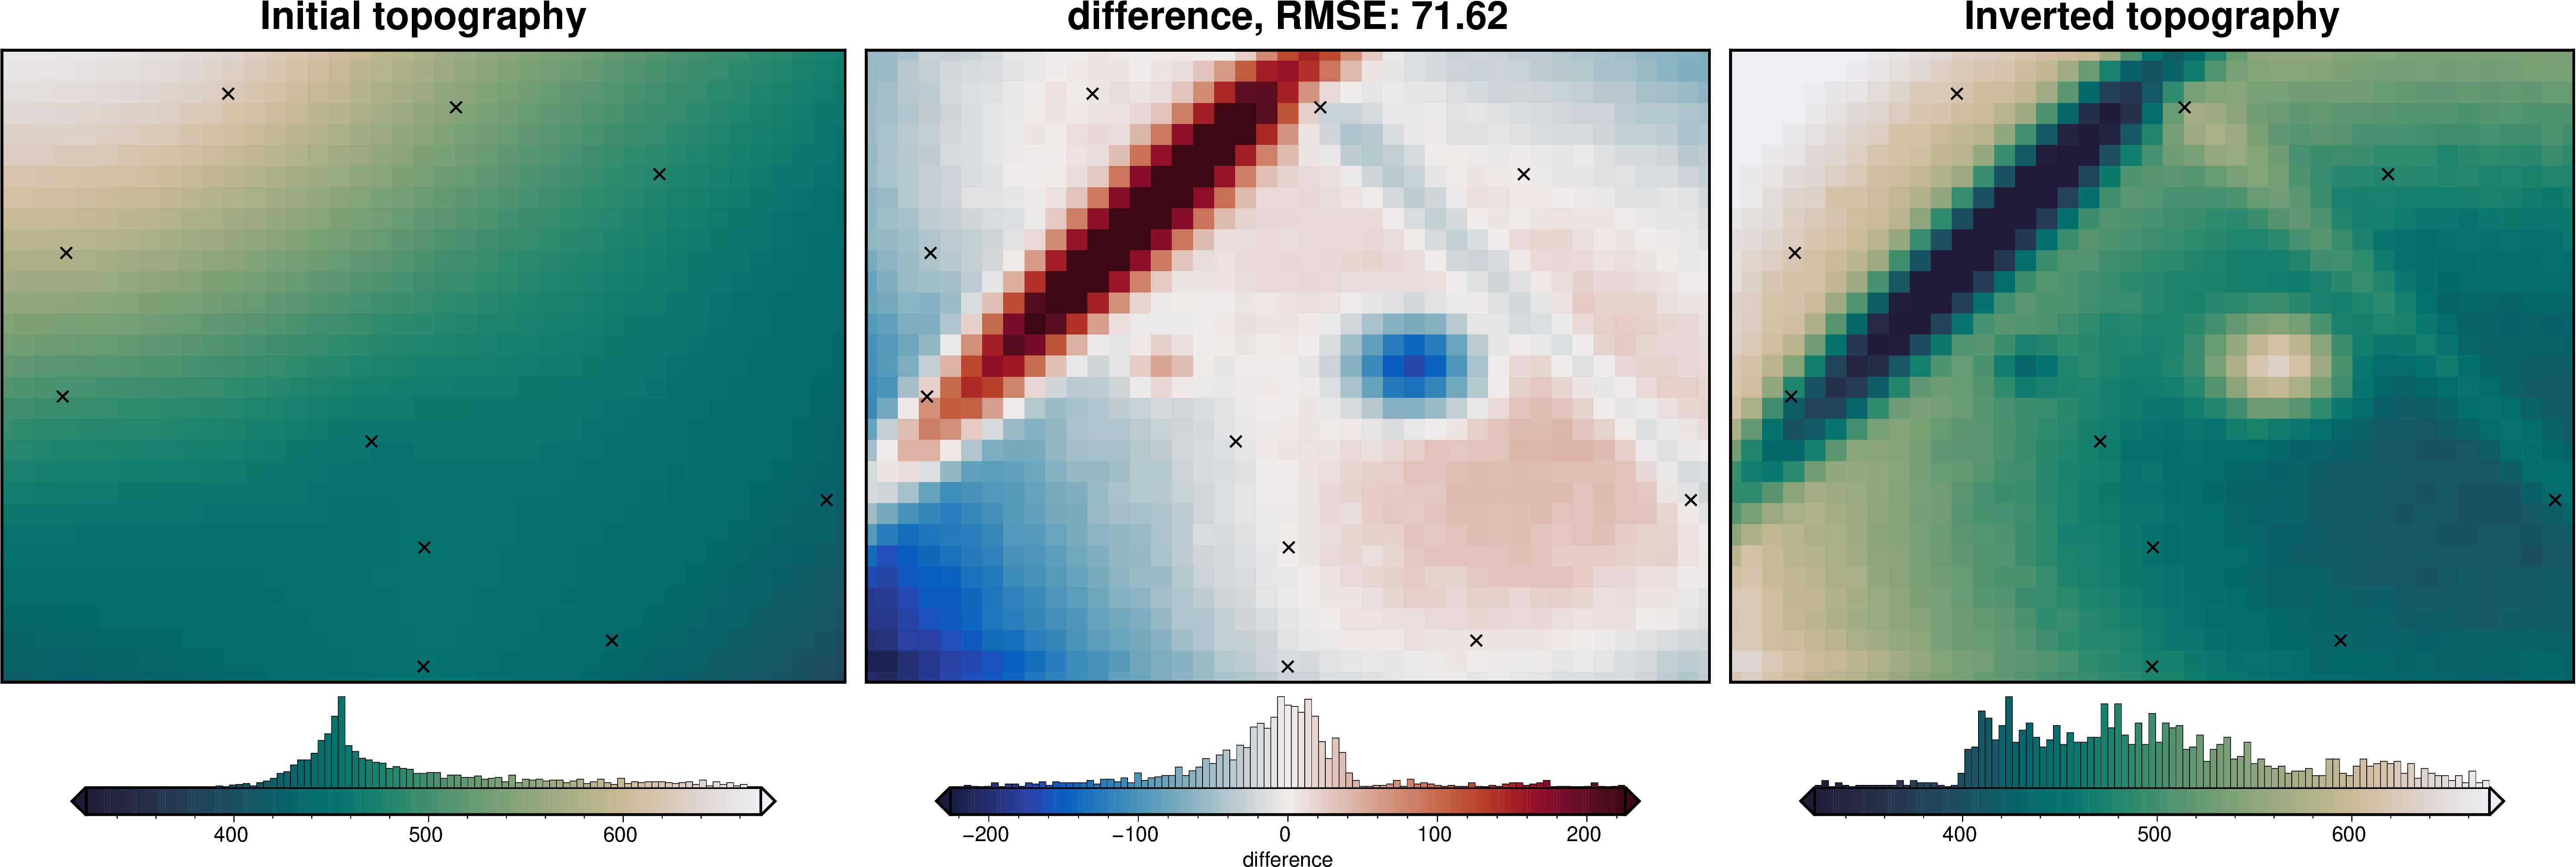

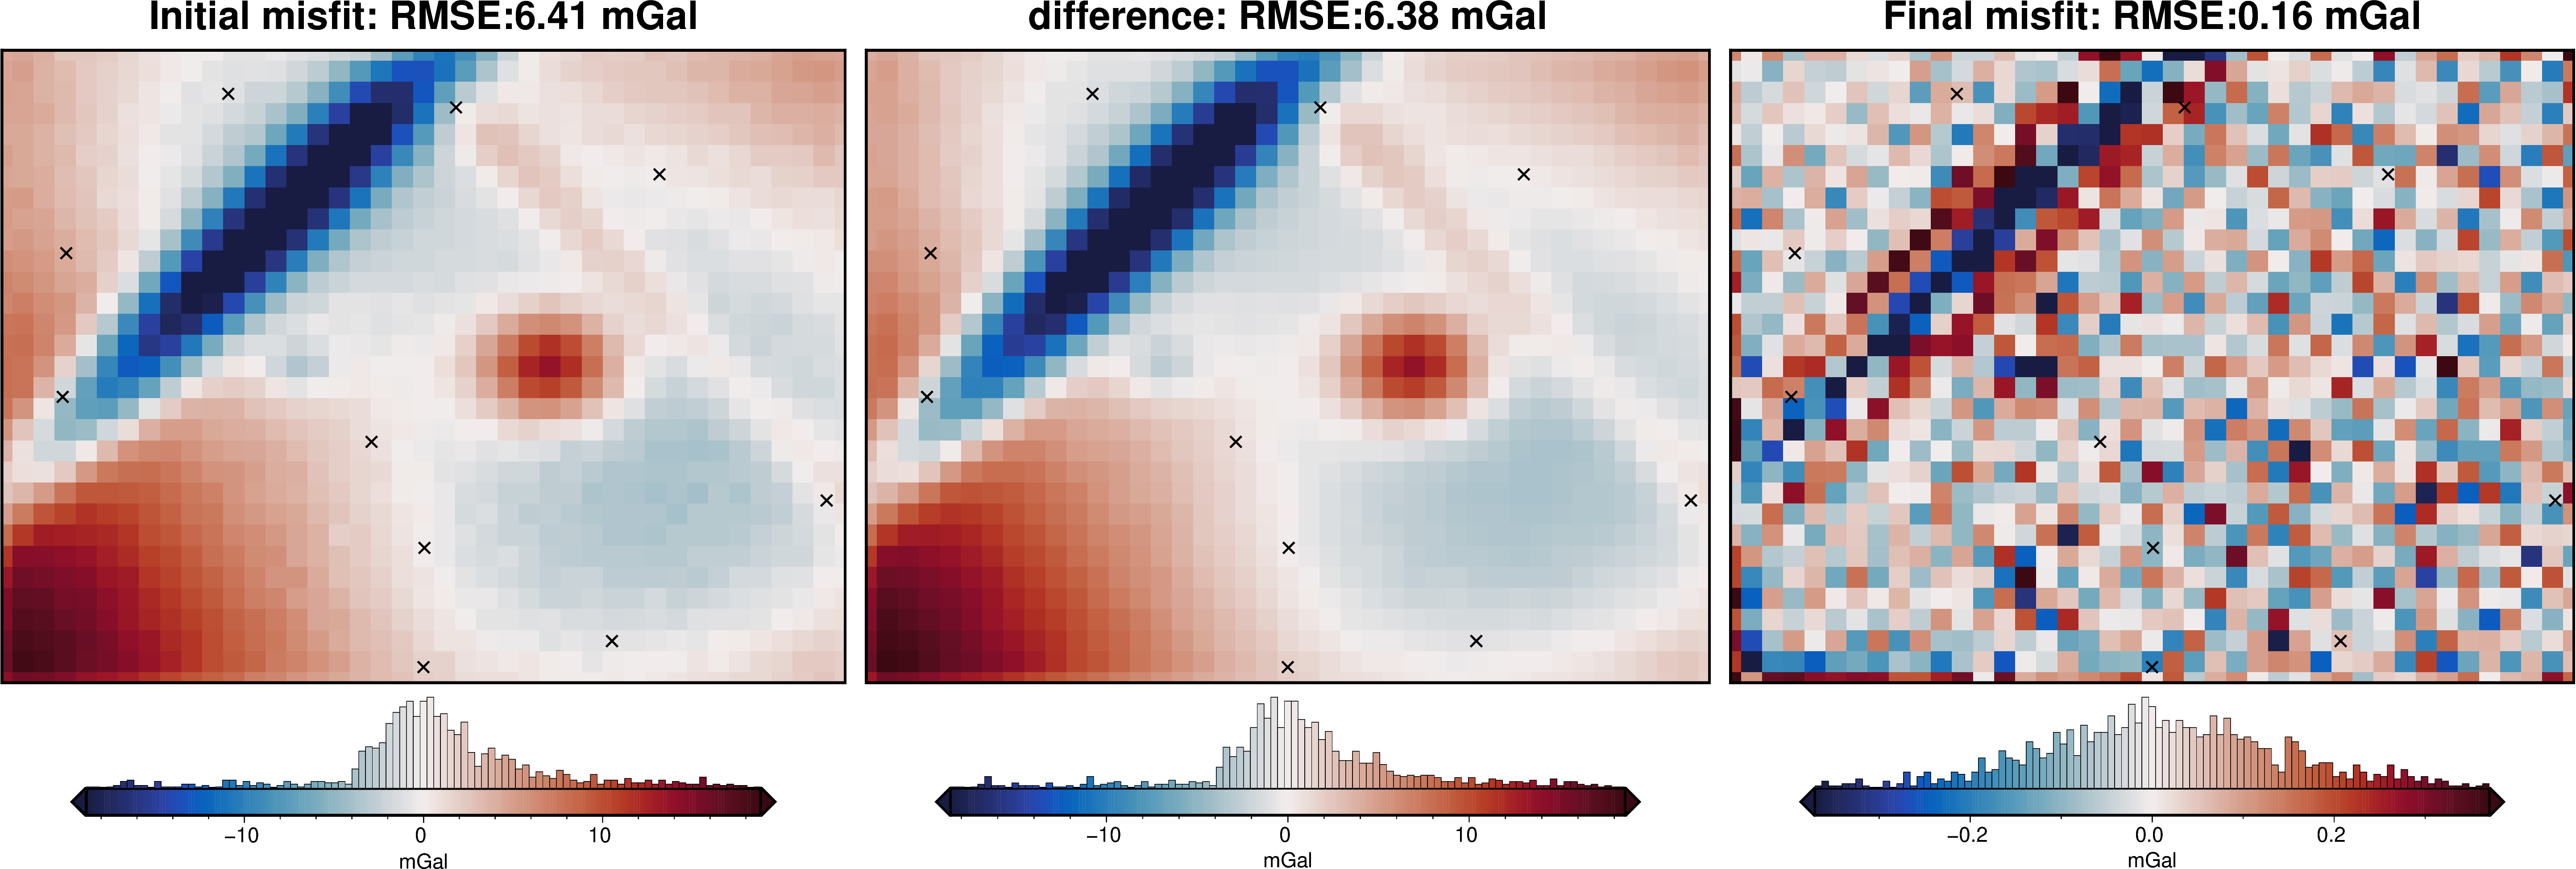

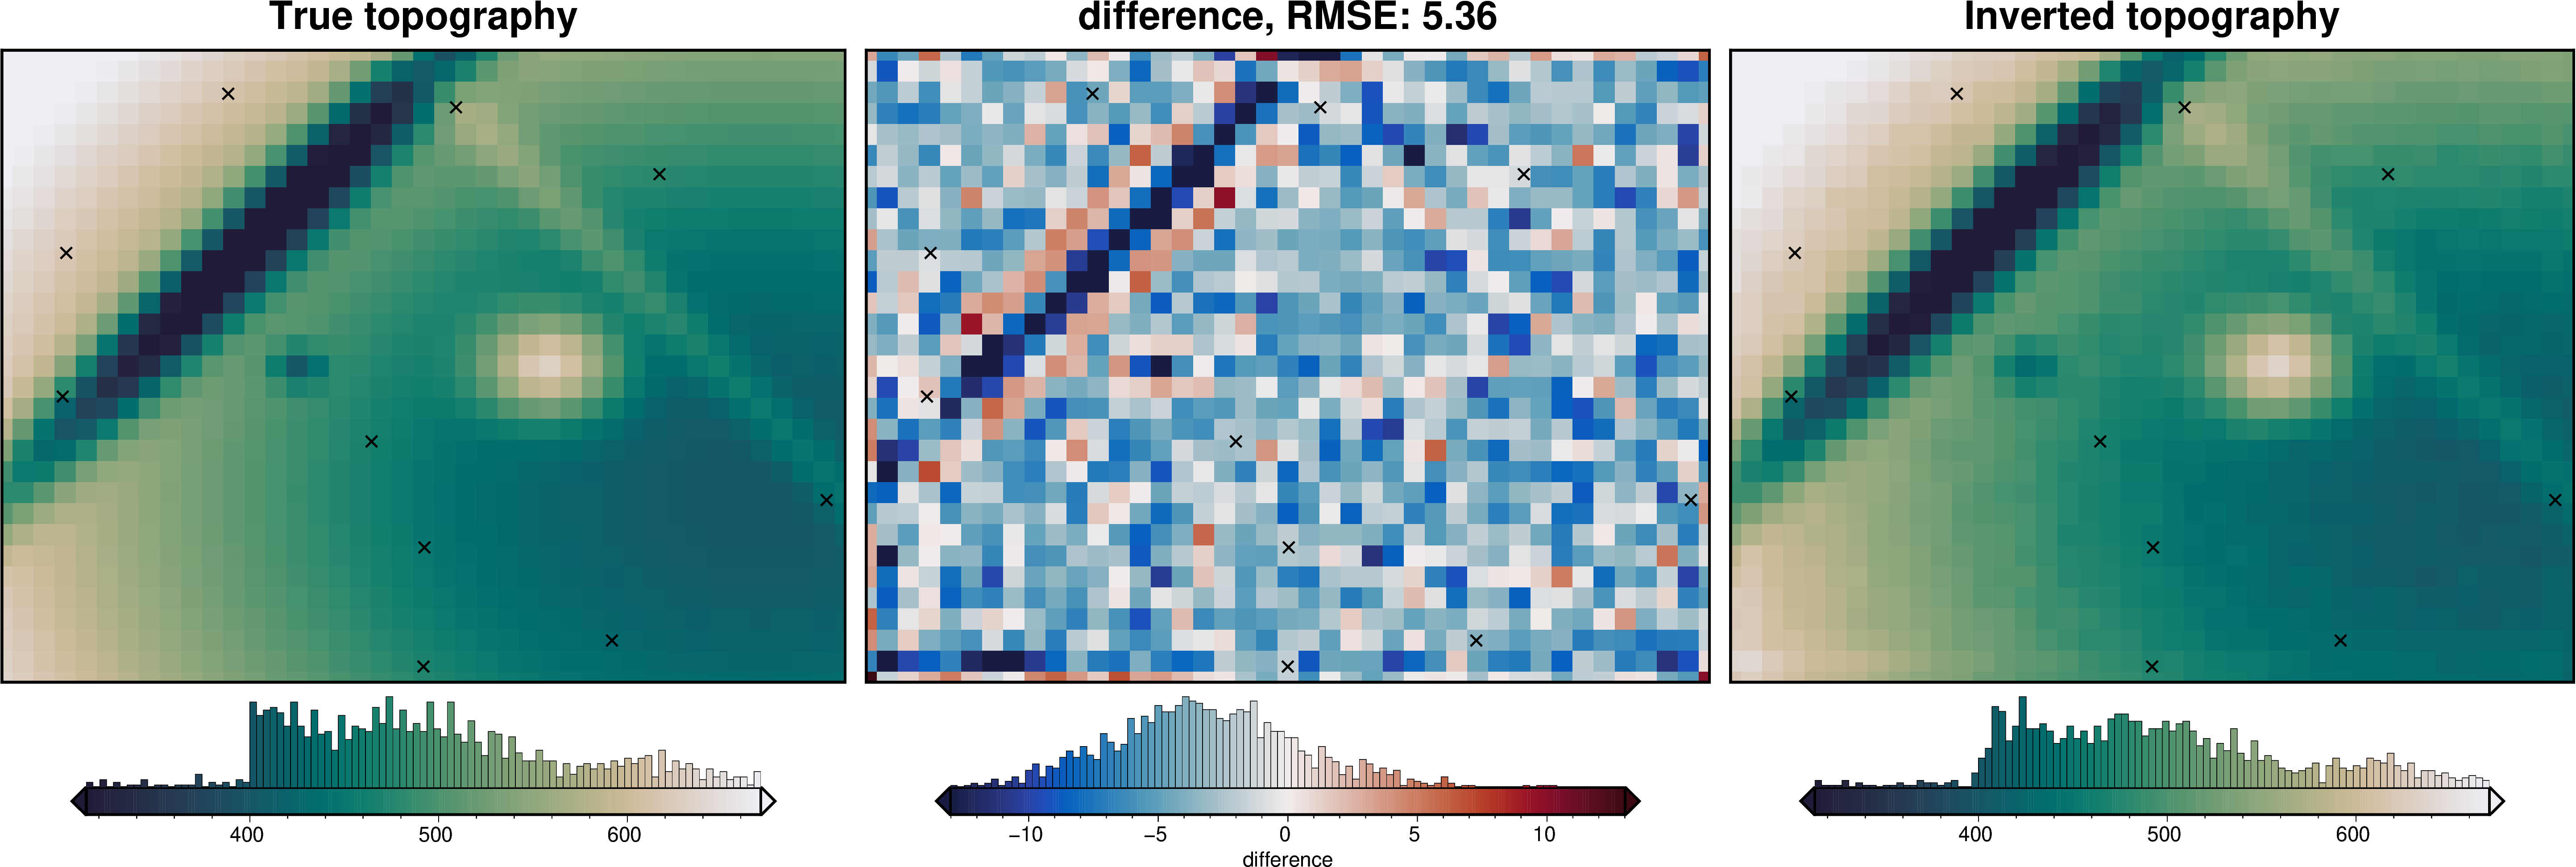

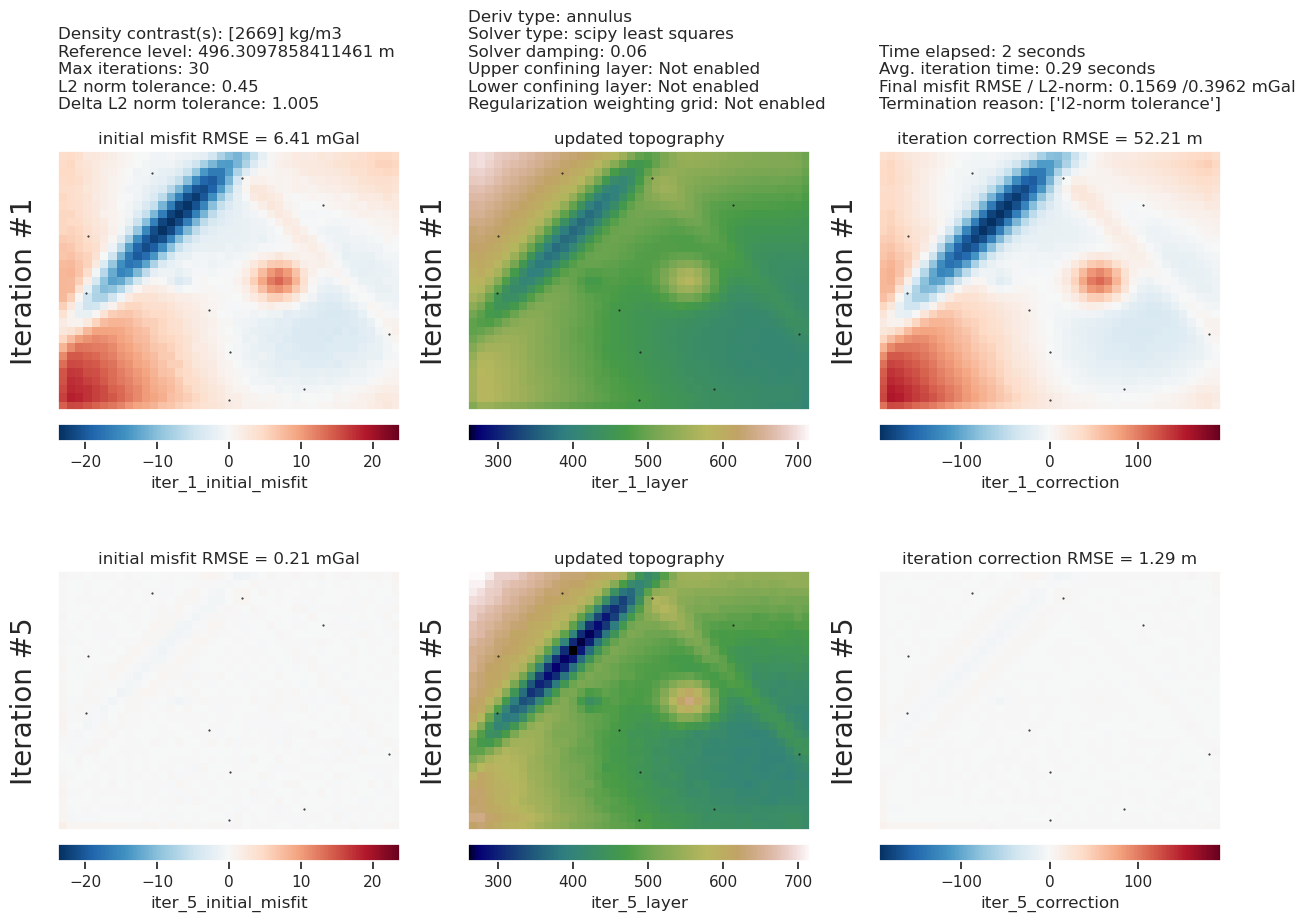

In [8]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    constraints_df=constraint_points,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

In [9]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 2.90 m


In [10]:
constraint_points

,easting,northing,upward,starting_topography,inverted_topography
0,3052.331575,20376.899884,619.779099,580.163740,621.896327
1,31196.751690,24112.171083,479.563412,481.652035,481.298138
2,17536.369258,11428.233994,465.786893,458.230368,468.312046
3,28938.607113,1978.090407,426.413502,438.512760,430.035485
4,39119.580480,8644.367979,428.773305,425.210470,432.648127
5,21539.834816,27287.805832,546.901160,547.287244,548.319978
6,20044.818546,6401.560607,450.406755,455.069067,451.832853
7,2882.045334,13563.718855,460.979806,499.138482,459.140055
8,10737.559204,27936.180591,614.084318,624.948915,619.697658
9,19995.300033,746.976827,470.409607,452.397262,472.253582


The RMSE between the constraint's true values and the inverted topography at the constraint's is not 0. This shows that while the starting model helped the inversion, the actual values of the constraints is not adhered too. The next inversion (`adhering_to_constraints.ipynb`) will show how to help the model stick to the constraints. 